Capilano University Unoccupied Room Finder
---------------------
#### Name: Shayan Heidari
This project is a tool to find available(unoccupied) rooms in Capilano University to use as study spaces.

### Tools used:
* `matplotlib`: Graping the room begin times and end times.
* `requests`: Grabbing data from the portal.
* Chrome devtools to inspect the network requests which are made while searching for classes.
* Visual JSON viewer at [http://jsonviewer.stack.hu](http://jsonviewer.stack.hu/) to make sense of the data we're getting back.


This is achieved by using the guest registration portal. Everything is given to the client via XHR so it was very easy to use the portal as sort of a Frankenstein API.

The building blocks of this project were formed by staring at chrome devtools while gathering class data.

Graphing is simple and it's achieved by using matplot's `vlines`


### Credits:
* "Generate timetable using matplotlib"
    * [https://masudakoji.github.io/2015/05/23/generate-timetable-using-matplotlib/en/](https://masudakoji.github.io/2015/05/23/generate-timetable-using-matplotlib/en/)
    * by Koji Masuda
        * This bit of code was a bit helpful to reflect the x and y ticks. Even though their project was trying to achieve the same thing as me, I simply found it too complicated for this pupose since not much eye candy was required.



## Data Gathering

In [1]:
import requests, json
from pprint import pprint
from dataclasses import dataclass
import matplotlib.pyplot as plt

This is used to acquire an http `session` throughout this entire program in order to retain cookies and different session headers. 

Using sessions is also recommended for better performance and reduces latency in the intiation of each request.

In [2]:
session = requests.Session()

This hardcoded bit is the sort of cryptic date that refers to Spring of 2023.

A better version of this bit would include a list of available terms to look at with their corresponding names and cryptic date.

This declaration is extremely important. As can be seen later.

In [3]:
termData = {'term': '202310'}

The term `offset` is the offset from the beginning of the class list.

For example, to get the 400th class in a request size of 200, the offset needs to be 200.

This is extremely useful to get every single class within a for loop.

In [4]:
offset = 0

Hardcoded and has to stay. The backend gives no indication of hitting the request size limit and simply truncates the output with no error.

The 200 value is a tested limit. 

In [5]:
requestSize = 200

For some reason, the server only lets our class search come back with full results if we have previously decalred to it, using a post request, what term we're looking for.

This "setting" on the server is then rememberd by using our `JSESSIONID` in the cookies. This is why it's crucial to use http sessions.

In [6]:
session.post('https://ssb9s.capilanou.ca:8443/StudentRegistrationSsb/ssb/term/search?mode=search',
             data=termData)

<Response [200]>

The URL used to acquire results needs the term we're requesting even though we've set it in the previous code block, page offset and request size which are crucial.

Sorting does not matter at all since all the data is structured internally and then graphed.

In [7]:
requestUrl = f"https://ssb9s.capilanou.ca:8443/StudentRegistrationSsb/ssb/searchResults/searchResults?txt_term={termData['term']}&startDatepicker=&endDatepicker=&pageOffset={offset}&pageMaxSize={requestSize}&sortColumn=subjectDescription&sortDirection=asc"

Simply making a request to the and storing its reponse in an string format, loading it using the json library to a python dictionary so we can work with it.

In [8]:
rawData = session.get(requestUrl).text
jsonData = json.loads(rawData)


Only the reponse's `data` portion is useful to us.

In [9]:
data = jsonData['data']

If the university changes their registration system, this project can still be prototyped using the static data stored in the samples folder.

**Only uncomment if the http requests fail** 

In [10]:
#with open('Data Samples/spring22_200_data', 'r') as f:
#    data = json.loads(f.read())['data']

This class was used before realizing the need to use sets instead of sets.

Its usage can be seen in previous commits but it's been replaced for now.

Still very helpful tho. 

In [11]:
@dataclass
class Monday:
    roomname:str
    begintime: int
    endtime: int
    # test
    index: int
    # test

    @classmethod
    def room(cls, data, num):
        roomname = data['buildingDescription'] + data['room']
        begintime = data['beginTime']
        endtime = data['endTime']
        #test
        index = num
        #test

        return Monday(roomname, begintime, endtime, index)

Function to develop a valid list of rooms with classes taking place on Monday.

The valid entries in the data would have to follow these conditions:
* The `meetingsFaculty` should not be empty, since such entry would be an asynchronous online class.
* the `building` entry inside `meetingsFaculty` should also not be empty and even if it's non empty, it should not be an `ON` or online class. since those are synchronous online classes. 

The long list comprehension was my solution to easily filter without many if consi

This compiles a set of classes which is a list of classes, nonrepeating. Crucial to making the graph happen the way I thought of it.




### Attention:
Even though the data is filtered properly here, the dataset still contains small inaccuracies. Some observed inaccuracies were for example, the `building` entry being called "off campus" instead of `ON` or "online". 

In [12]:
def roomSearch(data):
    c = 0
    
    monday = []
    
    roomList = set() # unique room Names. we can tolerate some inaccuracies.
    
    for i in data:
    #    print(c)
        if (len(i['meetingsFaculty']) != 0) and (len([e for e in [d for d in i['meetingsFaculty']]]) != 0):
            for f in i['meetingsFaculty']:
                if (f['meetingTime']['building'] != None) and (f['meetingTime']['building'] != "ON") :
                    section = f['meetingTime']
                    roomname = (section['buildingDescription'] + section['room'])
                    #print(roomname)
                    
                    # Hardcoded for now just to test the program.
                    if section['monday'] == True:
                        #monday.append(Monday.room(section, c))
                        roomList.add(roomname)
                        
    
    
        # For debugging purposes
        c += 1
    #print(monday)
    #return monday
    return list(roomList)


This function is almost the exact same as above but finds the nonrepeating rooms in the dataset and adds a tuple of begin and endtimes to the array within the `roomNHours` dictionary.

This is just to make the data very easy to graph with little code. Given, this is not a perfect solution.

The roomname is currently the full building name just to confirm the program for now. The shortened names such as BR for Birch will be implemented later.

In [13]:
def hourFind(rooms, data):
    c = 0
    roomNHours = {}
    
    for room in rooms:
        roomNHours[room] = [] # initiate the empty list to be filled with tuples
        
    for i in data:
    #    print(c)
        for room in rooms:
            if (len(i['meetingsFaculty']) != 0) and (len([e for e in [d for d in i['meetingsFaculty']]]) != 0):
                for f in i['meetingsFaculty']:
                    if (f['meetingTime']['building'] != None) and (f['meetingTime']['building'] != "ON") :
                        section = f['meetingTime']
                        roomname = (section['buildingDescription'] + section['room'])
                        #print(roomname)
                        if (section['buildingDescription'] + section['room']) == room:
                            #monday.append(Monday.room(section, c))
                            # Simple math to convert hour:min to floating point to make it
                            # suitable for graphing
                            beginTime = int( section["beginTime"][:2] ) + (int( section["beginTime"][-2:] ) * 100 / 60) / 100
                            endTime = int( section["endTime"][:2] ) + (int( section["endTime"][-2:] ) * 100 / 60) / 100
                            roomNHours[room].append( (beginTime, endTime) )
                        
    
    
    
        c += 1
    #print(monday)
    #return monday
    return roomNHours


For now, I know that the list of classes has only about 2000 entries but this data is provided to us in the first request. That's what also makes the browser experience possible.

This is a more compact version of the request explained above. This is a prototype for now.

In [14]:
#roomData = roomSearch(data)
for i in range(1):
    requestUrl = f"https://ssb9s.capilanou.ca:8443/StudentRegistrationSsb/ssb/searchResults/searchResults?txt_term={termData['term']}&startDatepicker=&endDatepicker=&pageOffset={offset}&pageMaxSize={requestSize}&sortColumn=subjectDescription&sortDirection=asc"
    data = json.loads(session.get(requestUrl).text)['data']
    hours = hourFind( roomSearch( data ), data )
    pprint(hours)
    offset += 200

{'Arbutus001': [(10.5, 12.333333333333334),
                (9.5, 11.333333333333334),
                (13.5, 15.333333333333334),
                (13.5, 15.333333333333334),
                (15.5, 17.333333333333332),
                (15.0, 16.833333333333332)],
 'Arbutus117': [(13.5, 15.333333333333334),
                (13.0, 14.833333333333334),
                (15.5, 17.333333333333332),
                (15.5, 17.333333333333332),
                (10.5, 12.333333333333334),
                (10.5, 12.333333333333334),
                (10.5, 12.333333333333334)],
 'Arbutus209': [(9.5, 13.333333333333334),
                (10.0, 13.833333333333334),
                (10.0, 13.833333333333334),
                (11.0, 12.833333333333334),
                (13.5, 15.333333333333334)],
 'Arbutus304': [(14.5, 17.333333333333332),
                (11.5, 14.333333333333334),
                (11.5, 14.333333333333334)],
 'Arbutus315': [(13.0, 14.333333333333334),
                (8.5, 9.833333

## Graphing

Set the plot size to 50 by 10, However, for actual graphing of the entire Monday classes. This needs to be set dynamically depending on the room size. 

Set font to 8, doesn't need to be set dynamically.

Enable y axis grids to make hours readable.

A one-time operation to set the x ticks so that there's room and entries on the graph for every room.

Set the xtick labels to room names. The main part.

Mirror the X and Y labels so that it's easier to look at the graph. A better revision is needed to divide the graph into subplots for easier viewing. 10 classes on each plot. To be added.

Iterate over and plot every dictionary entry

Save the plot into A pdf file for practical viewing. The file is written to the relative current directory.

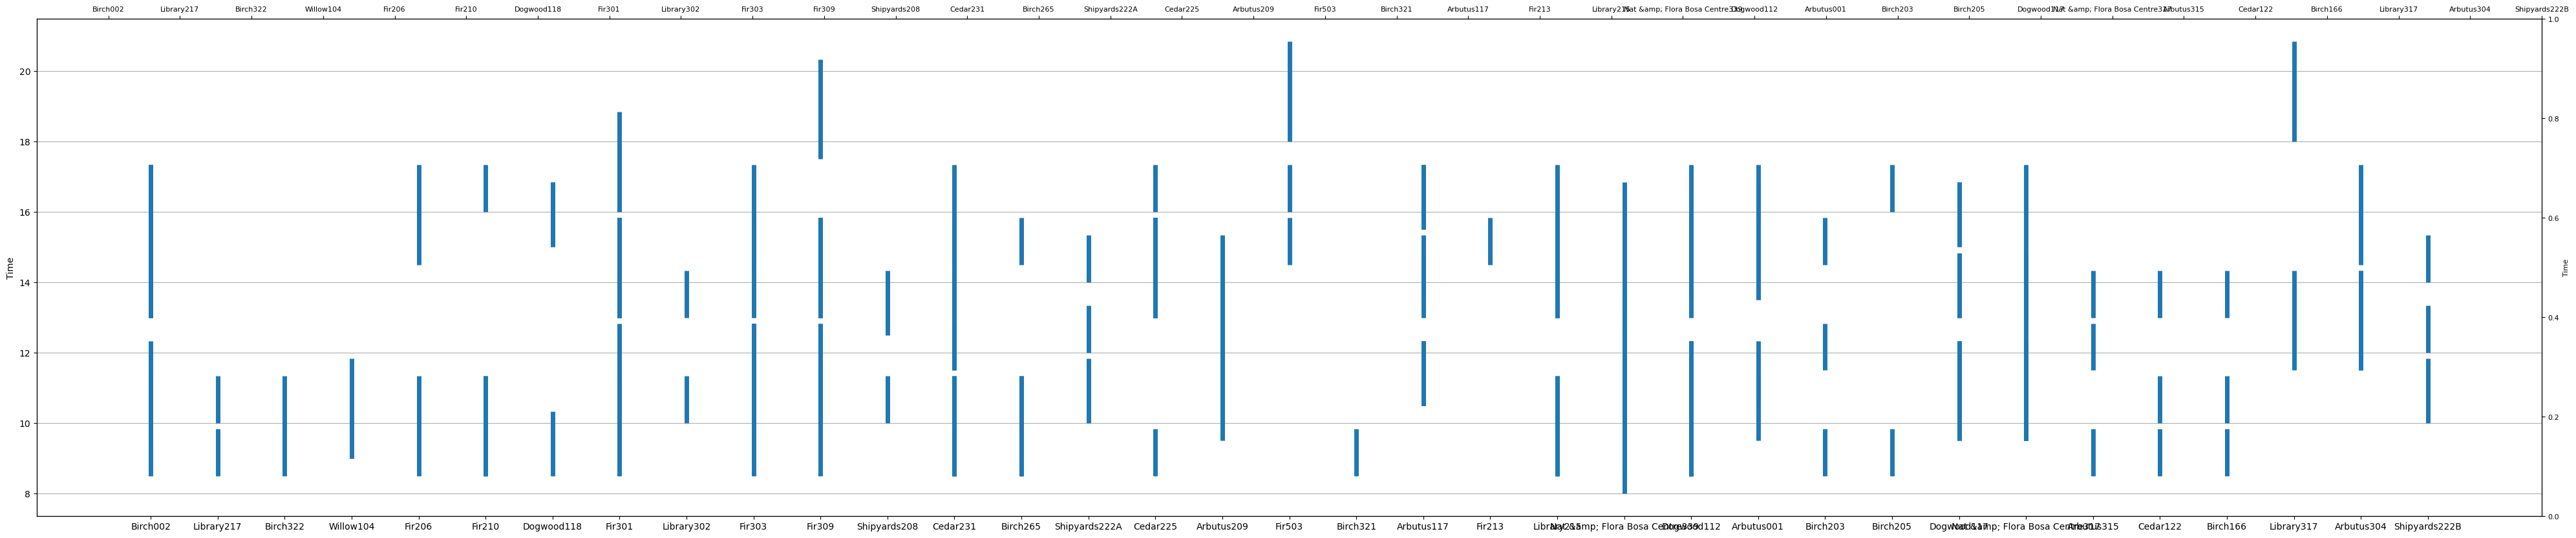

In [15]:
fig, ax = plt.subplots(figsize=(50, 10))

plt.rc('font', size=8)

ax.yaxis.grid()
ax.set_xticks( [i for i in range(1, len(hours)+1 )] )
ax.set_xticklabels( list(hours.keys()) )
ax.set_ylabel('Time')


'''
***************************************************************************************/
*    Title: Generate timetable using matplotlib
*    Author: Koji Masuda
*    Date: 2015
*    Availability: https://masudakoji.github.io/2015/05/23/generate-timetable-using-matplotlib/en/
*
***************************************************************************************/
'''
ax2=ax.twiny().twinx()
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels( list(hours.keys()) )
ax2.set_ylabel('Time')
'''
End of citation
'''


pos = 1
for h in hours:
    for t in hours[h]:
        ax.vlines( pos, t[0], t[1], linewidth=5)
    pos += 1
    
    
    
plt.savefig("First 200 results test plot 26 feb.pdf")